# Parsing PDFs With LLMs

Parsing PDFs with LLMs is exceedingly simple: we turn each page of the PDF into an image, and then pass that image to an LLM and nicely ask to get markdown back. It's a bit hard to believe, but this is currently the SOTA in document processing. 

To understand whether this strategy for parsing PDFs is a good idea, it's good to first look at alternative approaches.

Traditional OCR tools can parse PDFs! However, their understanding of the document is weaker than VLMs, and their extraction quality is often worse. If your documents have many different formats, traditional OCR can easily break. That's why the most sophisticated processing pipelines lean more heavily on VLMs.

On the other side of the spectrum we have tools like Unstructured, Reducto, and Chunkr. They first perform Document Layout Analysis to break a PDF into sections and extract any graphs, charts, or tables, then run a VLM on individual parts of a PDF. This has the added advantage of simplifying chunking, as each section is usually separate in some way from the rest. While this can be a necessity for complex documents, especially those with numbers that need to be correctly extracted with extremely high precision (like bank statements,) it is far from necessary for parsing most PDFs.

A Vision Language Model (VLM) can easily parse a document page, return markdown representative of all charts, images, and text on that page. It can also extract JSON, which traditional OCR models cannot do!

This pipeline is also extremely simple and can be implemented from scratch in a few lines of code.

And that's exactly what we'll be doing today! We'll be taking 1k arxiv papers and parsing them with VLMs.

## Converting PDF to Markdown
Let's try converting a PDF of a research paper to markdown with VLMs

First, we'll install openai so we can interact with Inference.net, and pdf2image to convert our pdf to individual images.

In [ ]:
!pip install pdf2image openai pillow requests markdown

Next we'll use the OpenAI Client to connect to Inference.net.

In [3]:
import requests, base64, os
from pdf2image import convert_from_bytes
from openai import OpenAI
from io import BytesIO

client = OpenAI(
    base_url="https://api.inference.net/v1", 
    api_key=os.getenv("INFERENCE_API_KEY")
)


Now let's fetch the arxiv paper and turn the PDF into a series of images:

In [4]:
# Download PDF
arxiv_id = "2301.07041"  # Change this to your paper
pdf_url = f"https://arxiv.org/pdf/{arxiv_id}.pdf"
pdf_bytes = requests.get(pdf_url).content
print(f"Downloaded {len(pdf_bytes)} bytes")

# Cell 4: Convert PDF to images
images = convert_from_bytes(pdf_bytes, dpi=150)
print(f"Converted to {len(images)} page images")

Downloaded 336344 bytes
Converted to 18 page images


We need a helper function to convert our images to base64 (we could also have done that in the previous step).

We also have a funciton to process tha page. We use a model that supports images (a VLM,) and give a detailed prompt so the LLM knows what to do.

This prompt could definitely be better, but in our case it did the trick. You can always steal the prompt from Unstructured, Chunkr, or any open-source document processing tool. I've had good results with this very simple prompt.

In [21]:
def img_to_uri(img):
    buf = BytesIO()
    img.save(buf, format='PNG')
    return f"data:image/png;base64,{base64.b64encode(buf.getvalue()).decode()}"

# Cell 6: Process single page through VLM
def process_page(img, page_num):
    response = client.chat.completions.create(
        model="meta-llama/llama-3.2-11b-instruct/fp-16",
        messages=[
            {"role": "system", "content": "Convert this academic paper page to clean markdown. Use proper headings, convert math to LaTeX ($$ for display, $ for inline), preserve tables and formatting. Make sure to include all text, tables, and images, and other content on the page."},
            {"role": "user", "content": [
                {"type": "image_url", "image_url": {"url": img_to_uri(img)}},
                {"type": "text", "text": f"Convert page {page_num} to markdown:"}
            ]}
        ],
        max_tokens=8000
    )
    return response.choices[0].message.content

Let's display the first image so we have some sense of the paper we are working with. I had ChatGPT recommend a paper, and this one looks fine to me.

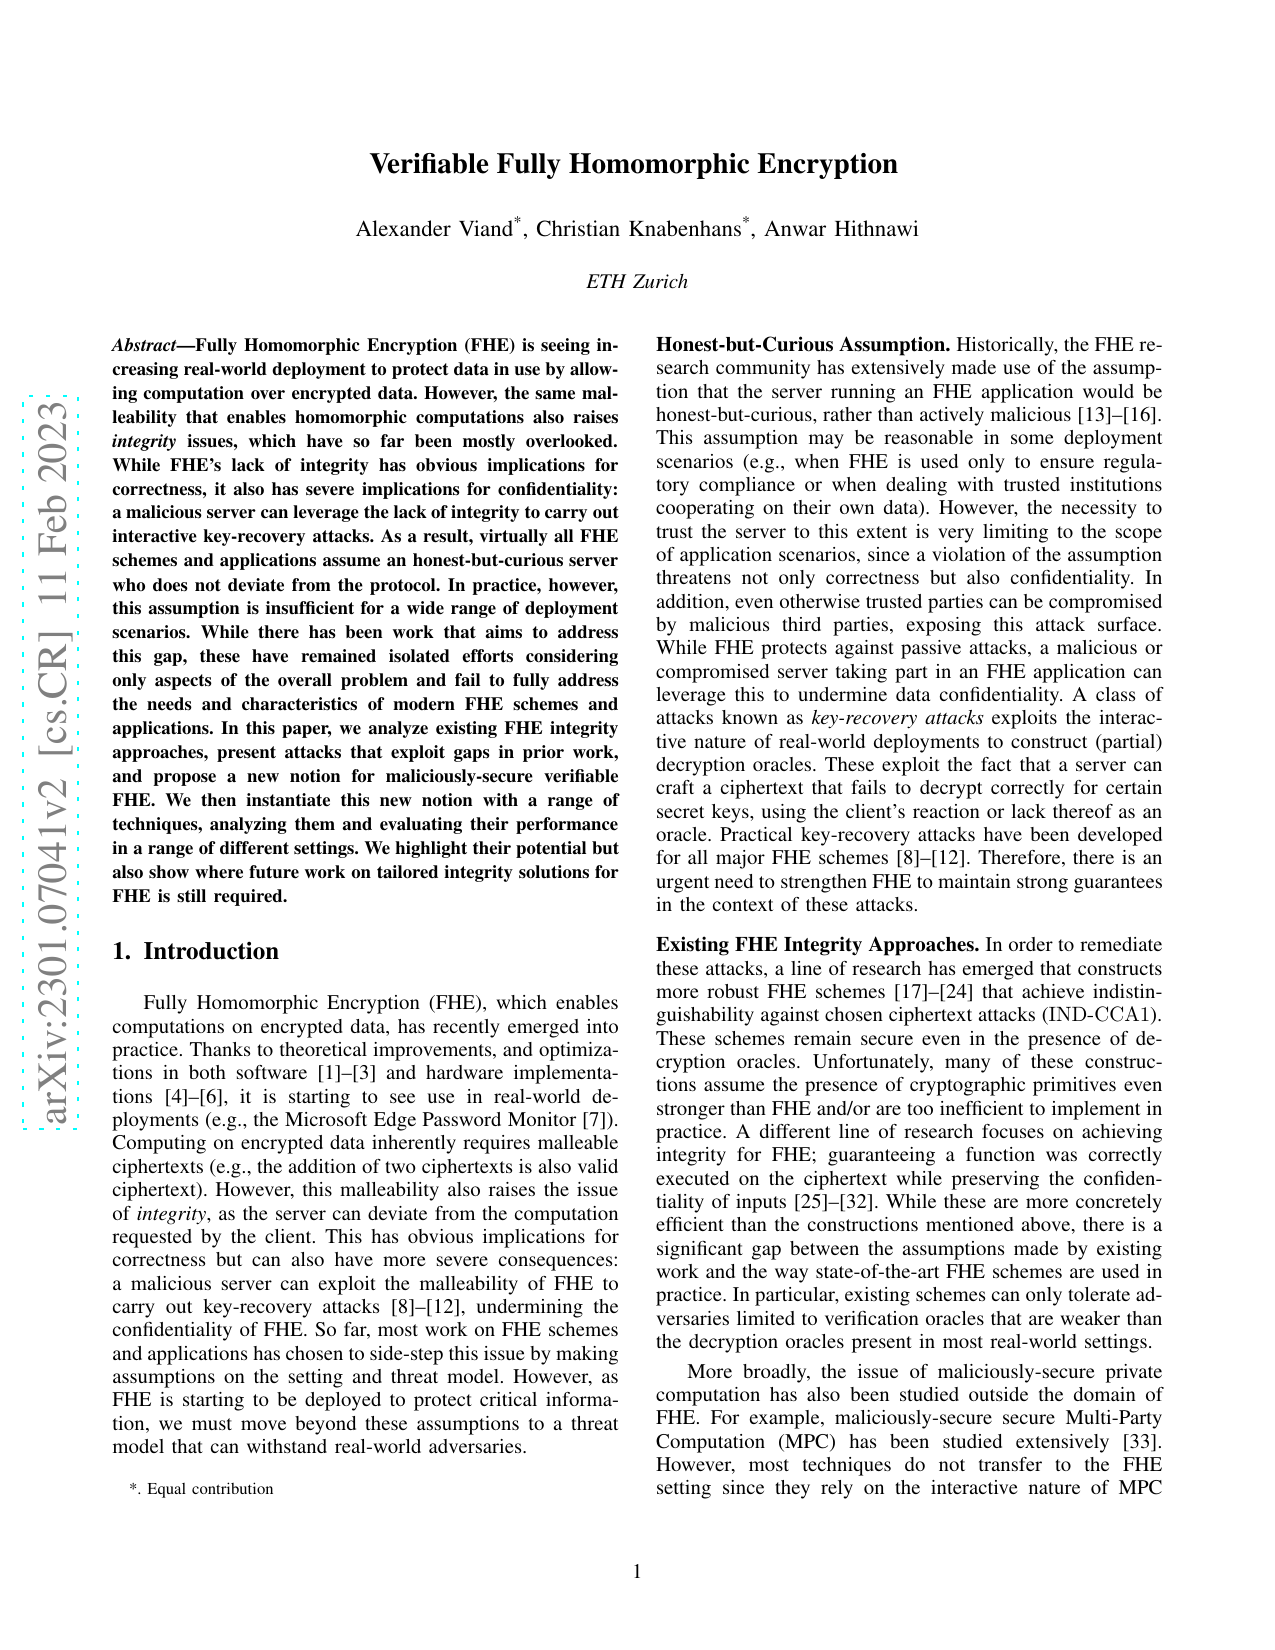

In [28]:
# display first three pages
display(images[0])

Now let's process all the papers in parallel. This is fine for individual papers, but let's imagine for a moment that we needed to process tens of thousands or even millions of papers--we would quickly hit rate limits! For large-scale processing, we recommend using either:

1. The Batch API - Process multiple requests in a single API call
2. The Async API - Queue requests for background processing

Both options are better for large scales and basically have no rate limits. Check out the docs at:
- Batch API: https://docs.inference.net/features/batch-api
- Async API: https://docs.inference.net/features/asynchronous-inference/overview


In [22]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm

def process_page_with_progress(args):
    i, img = args
    return i, process_page(img, i+1)

# Process pages in parallel
markdown_pages = [None] * len(images)
with ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(process_page_with_progress, (i, img)) 
              for i, img in enumerate(images)]
    
    # Store results in order as they complete
    results = []
    for future in tqdm(as_completed(futures), 
                      total=len(images), 
                      desc="Converting pages to markdown",
                      unit="page"):
        results.append(future.result())
    
    # Sort results by page number and store in markdown_pages
    results.sort(key=lambda x: x[0])
    for i, markdown in results:
        markdown_pages[i] = markdown

# Combine and display
full_markdown = "\n\n---\n\n".join(markdown_pages)
print("\nCONVERTED PAPER:")
print("=" * 50)
print(full_markdown[:2000] + "..." if len(full_markdown) > 2000 else full_markdown)

# Save to file
with open("paper.md", "w") as f:
    f.write(full_markdown)
print("\nSaved to paper.md")

Converting pages to markdown:   0%|          | 0/18 [00:00<?, ?page/s]


CONVERTED PAPER:
# Verifiable Fully Homomorphic Encryption

## Abstract

Fully Homomorphic Encryption (FHE) is seeing increasing real-world deployment to protect data in use by allowing computation over encrypted data. However, the same malleability that enables homomorphic computations also raises integrity issues, which have so far been mostly overlooked. While FHE's lack of integrity has obvious implications for correctness, it also has severe implications for confidentiality: a malicious server can leverage the lack of integrity to carry out interactive key-recovery attacks. As a result, virtually all FHE schemes and applications assume an honest-but-curious server who does not deviate from the protocol. In practice, however, this assumption is insufficient for a wide range of deployment scenarios. While there has been work that aims to address this gap, these have remained isolated efforts considering only aspects of the overall problem and fail to fully address the needs and cha

Looks like we have the entire paper now as markdown. We can view the markdown in [paper.md](paper.md) or just run the cell below to read the processed paper. Right now it just shows the abstract, but remove the slice to see the full parsed paper.

Out tiny 11B model did a great job for literally pennies!

In [35]:
import markdown
from IPython.display import HTML

html_output = markdown.markdown(full_markdown)
# show the parsed abstract
display(HTML(html_output[:1488]))
